Ejemplos 18. Se va a comparar la solución analítica de la posición, velocidad y aceleración del émbolo (simbólico)
con las numéricas obtenidas utilizando las instrucciones gradient y derivative, tomando un paso h=0.01 y
considerando que L1=1, L2=2. La comparación se realiza en una vuelta, cada n grados.

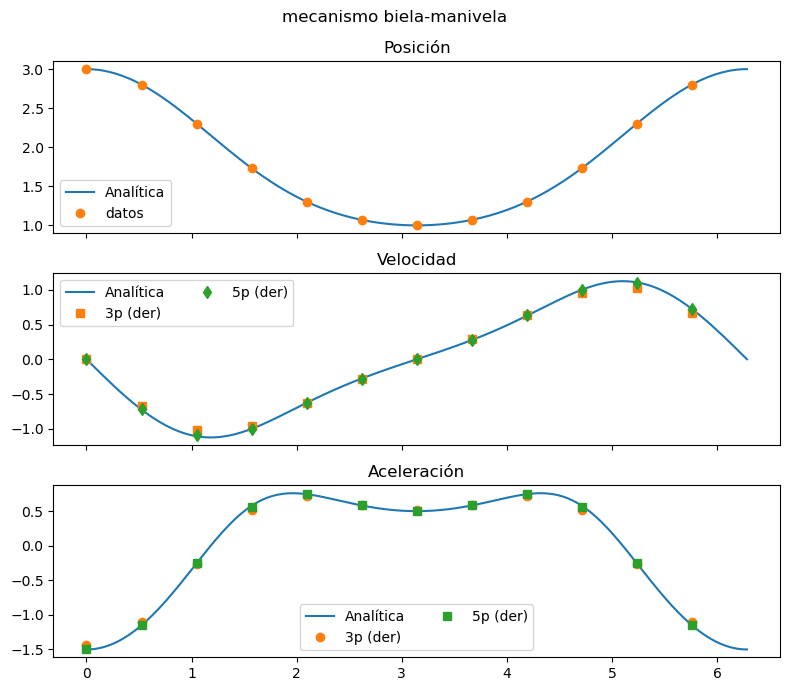

In [1]:
# ==============================================
# 1) Librerías y valores iniciales
# ==============================================
import sympy as sp                 # Cálculo simbólico (derivadas/expresiones)
import numpy as np                 # Cálculo numérico (vectores/arreglos)
import matplotlib.pyplot as plt    # Gráficas

# Parámetros del mecanismo (longitudes L1, L2), paso h (en rad) y n (grados)
L1, L2, h, n = (1, 2, 0.01, 30)

# ==============================================
# 2) Variables y funciones simbólicas
# ==============================================
xs = sp.symbols('xs', real=True)   # Ángulo simbólico
a  = sp.symbols('L_:2', real=True) # Crea símbolos a[0]=L_0 y a[1]=L_1

# Asignación numérica para las longitudes
valor = {a[0]: L1, a[1]: L2}

# Posición simbólica x(θ) del émbolo para una biela-manivela (modelo clásico)
pos = a[0]*sp.cos(xs) + sp.sqrt(a[1]**2 - a[0]**2*sp.sin(xs)**2)

# Derivadas simbólicas: velocidad y aceleración (respecto a θ)
vel = sp.diff(pos, xs).simplify()
ace = sp.diff(vel, xs).simplify()

# ==============================================
# 3) Conversión a funciones numéricas (lambdify)
# ==============================================
posa = sp.lambdify(xs, pos.subs(valor))  # x(θ)
vela = sp.lambdify(xs, vel.subs(valor))  # x'(θ)
acea = sp.lambdify(xs, ace.subs(valor))  # x''(θ)

# Malla “fina” para comparar y graficar (201 puntos de 0 a 2π)
Theta = np.linspace(0, 2*np.pi, 201)
Xa = posa(Theta)     # Posición analítica
Va = vela(Theta)     # Velocidad analítica
Aa = acea(Theta)     # Aceleración analítica

# ==============================================
# 4) Cálculos cada n grados  (ARREGLO PERIODICIDAD)
# ==============================================

puntos = int(np.ceil(360/n))              # Calcula el número de puntos según el paso angular n (en grados)
theta  = np.linspace(0, 2*np.pi, puntos,  # Genera los ángulos igualmente espaciados entre 0 y 2π
                     endpoint=False)      # Evita duplicar el punto final 2π (mantiene periodicidad)
Xn     = posa(theta)                      # Evalúa la posición analítica en cada ángulo θ
dtheta = theta[1] - theta[0]              # Calcula el incremento angular entre puntos consecutivos

# ==============================================
# 5) Derivadas numéricas periódicas
#     (central, usando np.roll para desplazar el arreglo)
# ==============================================

# ---- 3 puntos (O(h^2)) ----
# Fórmulas centrales clásicas de 3 puntos (segundo orden)
# Primera derivada: f'(x) ≈ (f(x+h) - f(x-h)) / (2h)
Vn3d = (np.roll(Xn, -1) - np.roll(Xn, 1)) / (2*dtheta)

# Segunda derivada: f''(x) ≈ (f(x+h) - 2f(x) + f(x-h)) / h²
An3d = (np.roll(Xn, -1) - 2*Xn + np.roll(Xn, 1)) / (dtheta**2)

# ---- 5 puntos (O(h^4)) ----  (RECOMENDADO)
# Fórmulas centrales de 5 puntos (cuarto orden de precisión)
# Primera derivada: (-f(x+2h) + 8f(x+h) - 8f(x-h) + f(x-2h)) / (12h)
Vn5d = (-np.roll(Xn, -2) + 8*np.roll(Xn, -1)
        - 8*np.roll(Xn,  1) +  np.roll(Xn,  2)) / (12*dtheta)

# Segunda derivada: (-f(x+2h)+16f(x+h)-30f(x)+16f(x-h)-f(x-2h)) / (12h²)
An5d = (-np.roll(Xn, -2) + 16*np.roll(Xn, -1) - 30*Xn
        + 16*np.roll(Xn,  1) -  np.roll(Xn,  2)) / (12*dtheta**2)

# ---- 7 puntos (O(h^6)) ----  (OPCIONAL, aún más exacto)
# Fórmulas centrales de 7 puntos (sexto orden de precisión)
# Primera derivada: (f(-3)-9f(-2)+45f(-1)-45f(1)+9f(2)-f(3)) / (60h)
Vn7d = ( np.roll(Xn,  3) - 9*np.roll(Xn,  2) + 45*np.roll(Xn,  1)
        -45*np.roll(Xn, -1) + 9*np.roll(Xn, -2) -  np.roll(Xn, -3)) / (60*dtheta)

# Segunda derivada:
# (2f(-3)-27f(-2)+270f(-1)-490f(0)+270f(1)-27f(2)+2f(3)) / (180h²)
An7d = ( 2*np.roll(Xn,  3) - 27*np.roll(Xn,  2) + 270*np.roll(Xn,  1)
        -490*Xn
        +270*np.roll(Xn, -1) - 27*np.roll(Xn, -2) +  2*np.roll(Xn, -3)) / (180*dtheta**2)

# ==============================================
# 6) Gráficas de comparación
# ==============================================
fig, ax = plt.subplots(3, 1, figsize=(8, 7), sharex=True)
plt.suptitle("mecanismo biela-manivela")

# --- Posición ---
ax[0].set_title("Posición")
ax[0].plot(Theta, Xa, label="Analítica")
ax[0].plot(theta, Xn, "o", label="datos")
ax[0].legend()

# --- Velocidad ---
ax[1].set_title("Velocidad")
ax[1].plot(Theta, Va, label="Analítica")
ax[1].plot(theta, Vn3d, "s", label="3p (der)")   # 3 puntos (central)
ax[1].plot(theta, Vn5d, "d", label="5p (der)")   # 5 puntos (central)
ax[1].legend(ncol=2)

# --- Aceleración ---
ax[2].set_title("Aceleración")
ax[2].plot(Theta, Aa, label="Analítica")
ax[2].plot(theta, An3d, "o", label="3p (der)")   # segunda derivada 3p
ax[2].plot(theta, An5d, "s", label="5p (der)")   # segunda derivada 5p
ax[2].legend(ncol=2)

fig.tight_layout()
plt.show()


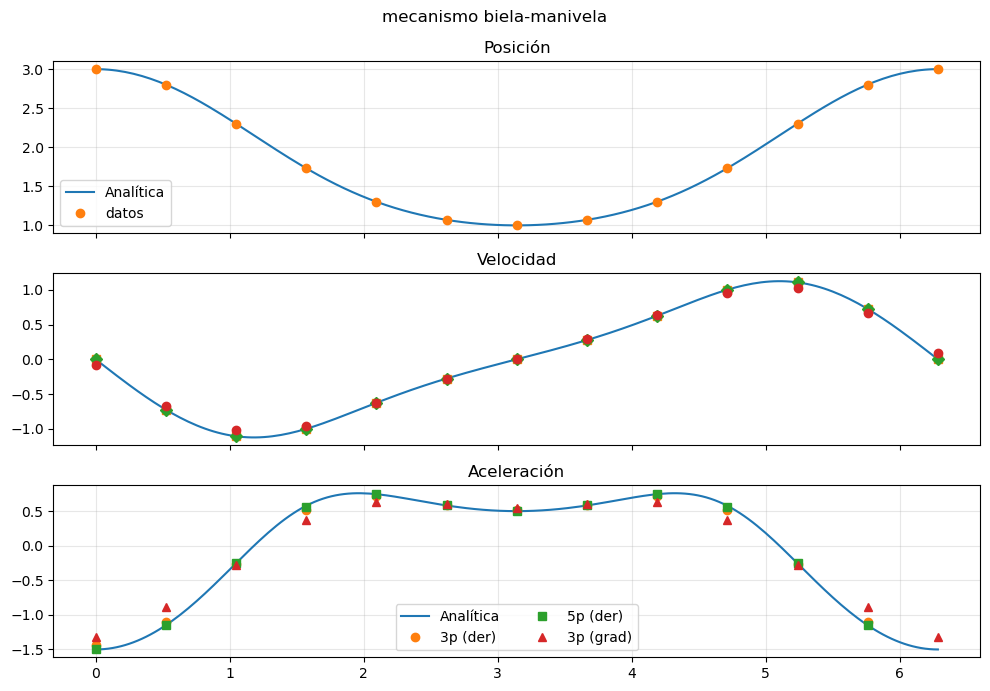

In [2]:
# ================================
# 1. Carga de las librerías y valores iniciales
# ================================
import sympy as sp                 # Librería para cálculo simbólico
import numpy as np                 # Librería para cálculo numérico con matrices y vectores
from scipy.differentiate import derivative  # Para derivadas numéricas
import matplotlib.pyplot as plt    # Librería para graficar resultados

L1, L2, h, n = (1, 2, 0.01, 30)    # Valores iniciales: longitudes L1, L2, paso h y número n

# ================================
# 2. Definición genérica de variables y funciones simbólicas
# ================================
xs = sp.symbols('xs', real=True)   # Ángulo simbólico
a = sp.symbols("L_:2", real=True)  # Crea símbolos L_0 y L_1 como variables reales
valor = {a[0]: L1, a[1]: L2}       # Asigna valores numéricos a los símbolos creados

# Definición de la posición simbólica en función de xs
pos = (a[0]*sp.cos(xs) + sp.sqrt(a[1]**2 - a[0]**2*sp.sin(xs)**2))

# Derivadas simbólicas de posición (velocidad y aceleración)
vel = pos.diff(xs).simplify()      # Primera derivada: velocidad
ace = vel.diff(xs).simplify()      # Segunda derivada: aceleración

# ================================
# 3. Conversión a funciones numéricas para comparar y representar
# ================================
# Convierte las expresiones simbólicas a funciones numéricas (lambdify)
posa = sp.lambdify(xs, pos.subs(valor))  # Función numérica de posición
vela = sp.lambdify(xs, vel.subs(valor))  # Función numérica de velocidad
acea = sp.lambdify(xs, ace.subs(valor))  # Función numérica de aceleración

# Define el rango de ángulos para evaluar (de 0 a 2π)
Theta = np.linspace(0, 2*np.pi, 201)

# Evalúa las funciones numéricas en el rango definido
Xa = posa(Theta)   # Posición
Va = vela(Theta)   # Velocidad
Aa = acea(Theta)   # Aceleración

# ================================
# 4. Cálculos cada n grados
# ================================
puntos = int(np.ceil(360/n) + 1)         # Calcula el número de puntos en base a n grados
theta = np.linspace(0, 2*np.pi, puntos)  # Genera los valores de θ
Xn = posa(theta)                         # Calcula posición numérica en esos puntos

# --- Usando derivative: sólo la primera derivada ---
Vn3d = derivative(posa, theta, order=2, maxiter=1, initial_step=h)  # Derivada numérica (orden 2)
Vn5d = derivative(posa, theta, order=4, maxiter=1, initial_step=h)  # Derivada numérica (orden 4)

# --- Usando gradient y encadenando derivadas ---
Vn3g = np.gradient(Xn, theta, edge_order=2)        # Derivada numérica (velocidad)
An3g = np.gradient(Vn3g, theta, edge_order=2)      # Segunda derivada (aceleración)

# --- Helpers para graficar con seguridad ---
def _yvals(v):
    """Extrae la parte numérica de un posible RichResult o array."""
    if hasattr(v, "df"):
        return np.asarray(v.df)
    if hasattr(v, "derivative"):
        return np.asarray(v.derivative)
    return np.asarray(v)

def _plot_xy(ax, x, y, *args, **kwargs):
    """Grafica x vs y recortando al mismo tamaño si difieren."""
    x = np.asarray(x); y = _yvals(y)
    m = min(x.shape[0], y.shape[0])
    ax.plot(x[:m], y[:m], *args, **kwargs)

# ============================
# 5) Representación de resultados
# ============================

fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)
plt.suptitle("mecanismo biela-manivela")

# ----- Posición -----
ax[0].set_title("Posición")
ax[0].plot(Theta, Xa, label="Analítica")
ax[0].plot(theta, Xn, "o", label="datos")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# ----- Velocidad -----
ax[1].set_title("Velocidad")
ax[1].plot(Theta, Va, label="Analítica")

if 'Vn3d' in locals():
    _plot_xy(ax[1], theta, Vn3d, "s", label="3p (der)")
if 'Vn5d' in locals():
    _plot_xy(ax[1], theta, Vn5d, "D", label="5p (der)")
if 'Vn3g' in locals():
    _plot_xy(ax[1], theta, Vn3g, "o", label="3p (grad)")

# ----- Aceleración -----
ax[2].set_title("Aceleración")
ax[2].plot(Theta, Aa, label="Analítica")

if 'An3d' in locals():
    _plot_xy(ax[2], theta, An3d, "o", label="3p (der)")
if 'An5d' in locals():
    _plot_xy(ax[2], theta, An5d, "s", label="5p (der)")
if 'An3g' in locals():
    _plot_xy(ax[2], theta, An3g, "^", label="3p (grad)")

ax[2].legend(ncol=2)
ax[2].grid(True, alpha=0.3)

fig.tight_layout()
plt.show()



In [3]:
import findiff

**Derivación: obtención de los coeficientes**

In [4]:
from fractions import Fraction
from collections.abc import Iterable

def dncoef_base(soporte, puntos, orden):
    """
    Calcula los coeficientes de una regla de derivación numérica
    usando los polinomios de la base de Lagrange definidos por 'soporte'.

    Parámetros:
    -----------
    soporte : lista o tupla
        Nodos del soporte (x_k)
    puntos : escalar o iterable
        Punto o puntos donde se evalúan las derivadas
    orden : int
        Orden de la derivada (entero >=0 y < len(soporte))

    Devuelve:
    ----------
    coef : lista de coeficientes (o lista de listas si 'puntos' es iterable)
    """

    # --- Funciones auxiliares ---
    def _is_scalar(x):
        return not isinstance(x, Iterable) or isinstance(x, (str, bytes, bytearray))

    def _poly_mul(p, q):
        res = [Fraction(0) for _ in range(len(p) + len(q) - 1)]
        for i, a in enumerate(p):
            for j, b in enumerate(q):
                res[i + j] += a * b
        return res

    def _poly_deriv(p, m=1):
        for _ in range(m):
            if len(p) == 1:
                return [Fraction(0)]
            p = [p[i+1] * (i+1) for i in range(len(p) - 1)]
        return p

    def _poly_eval(p, x):
        acc = Fraction(0)
        for c in reversed(p):
            acc = acc * x + c
        return acc

    def _lagrange_basis(xs, k):
        n = len(xs)
        num = [Fraction(1)]
        den = Fraction(1)
        xk = xs[k]
        for j, xj in enumerate(xs):
            if j == k:
                continue
            num = _poly_mul(num, [Fraction(-xj), Fraction(1)])
            den *= (xk - xj)
        num = [c / den for c in num]
        return num

    # --- 1) Comprobación de datos de entrada ---
    if not isinstance(soporte, (list, tuple)):
        raise TypeError("El soporte debe ser lista o tupla.")
    n = len(soporte)
    if not isinstance(orden, int) or not (0 <= orden < n):
        raise ValueError("El orden debe ser entero y menor que el número de nodos del soporte.")

    # Convertir a fracciones para exactitud
    xs = [Fraction(s).limit_denominator() for s in soporte]

    # --- 2) Base de Lagrange ---
    base = [_lagrange_basis(xs, k) for k in range(n)]

    # --- 3) Derivar cada polinomio de la base ---
    dbase = [_poly_deriv(p, orden) for p in base]

    # --- 4) Evaluar en el/los puntos ---
    def coef_en(a):
        aF = Fraction(a).limit_denominator()
        return [_poly_eval(p, aF) for p in dbase]

    if _is_scalar(puntos):
        return coef_en(puntos)
    else:
        return [coef_en(a) for a in puntos]


In [5]:
# Caso 1
xs1 = [i/12 for i in range(5)]
print(dncoef_base(xs1, 0, 1))
# → [-25, 48, -36, 16, -3]

# Caso 2
xs2 = [0, 1, 2, 3]
print(dncoef_base(xs2, 1, 2))
# → [1, -2, 1, 0]

# Caso 3
xs3 = [0, 0.5, 1, 1.5, 2]
print(dncoef_base(xs3, 0.5, 3))
# → [-12, 40, -48, 24, -4]


[Fraction(-25, 1), Fraction(48, 1), Fraction(-36, 1), Fraction(16, 1), Fraction(-3, 1)]
[Fraction(1, 1), Fraction(-2, 1), Fraction(1, 1), Fraction(0, 1)]
[Fraction(-12, 1), Fraction(40, 1), Fraction(-48, 1), Fraction(24, 1), Fraction(-4, 1)]


In [6]:
# --- Test cases with asserts ---

# Caso 1
xs1 = [i/12 for i in range(5)]
coef1 = dncoef_base(xs1, 0, 1)
print("Caso 1:", coef1)
assert coef1 == [-25, 48, -36, 16, -3], "❌ Caso 1 incorrecto"

# Caso 2
xs2 = [0, 1, 2, 3]
coef2 = dncoef_base(xs2, 1, 2)
print("Caso 2:", coef2)
assert coef2 == [1, -2, 1, 0], "❌ Caso 2 incorrecto"

# Caso 3
xs3 = [0, 0.5, 1, 1.5, 2]
coef3 = dncoef_base(xs3, 0.5, 3)
print("Caso 3:", coef3)
assert coef3 == [-12, 40, -48, 24, -4], "❌ Caso 3 incorrecto"

print("\n✅ Todos los casos verificados correctamente.")

def assert_suma_coef(soporte, a, m, tol=1e-10):
    alphas = dncoef_base(soporte, a, m)
    s = sum(alphas)
    if m == 0:
        assert abs(s - 1.0) < tol, f"Suma debe ser 1, obtuve {s}"
    else:
        assert abs(s) < tol, f"Suma debe ser 0, obtuve {s}"
    return alphas

# Casos del enunciado + verificación de suma
xs1 = [i/12 for i in range(5)]
a1  = 0
m1  = 1
coef1 = assert_suma_coef(xs1, a1, m1)             # también chequea suma==0
assert coef1 == [-25.0, 48.0, -36.0, 16.0, -3.0]

xs2 = [0, 1, 2, 3]
a2, m2 = 1, 2
coef2 = assert_suma_coef(xs2, a2, m2)
assert coef2 == [1.0, -2.0, 1.0, 0.0]

xs3 = [0, 0.5, 1, 1.5, 2]
a3, m3 = 0.5, 3
coef3 = assert_suma_coef(xs3, a3, m3)
assert coef3 == [-12.0, 40.0, -48.0, 24.0, -4.0]

print("✅ Suma de coeficientes verificada en los 3 casos.")



Caso 1: [Fraction(-25, 1), Fraction(48, 1), Fraction(-36, 1), Fraction(16, 1), Fraction(-3, 1)]
Caso 2: [Fraction(1, 1), Fraction(-2, 1), Fraction(1, 1), Fraction(0, 1)]
Caso 3: [Fraction(-12, 1), Fraction(40, 1), Fraction(-48, 1), Fraction(24, 1), Fraction(-4, 1)]

✅ Todos los casos verificados correctamente.
✅ Suma de coeficientes verificada en los 3 casos.


In [7]:
from collections.abc import Iterable
from math import isclose

def dncoef_base_simple(soporte, puntos, orden, *, tol=1e-12, redondear_enteros=True):
    """
    Igual que dncoef_base pero con floats (sin fractions).

    soporte : lista/tupla de nodos
    puntos  : escalar o iterable
    orden   : orden de la derivada
    tol     : tolerancia para redondear valores muy cercanos a enteros
    redondear_enteros : si True, convierte 2.999999999999 -> 3
    """

    def _is_scalar(x):
        return not isinstance(x, Iterable) or isinstance(x, (str, bytes, bytearray))

    def _poly_mul(p, q):
        res = [0.0]*(len(p)+len(q)-1)
        for i, a in enumerate(p):
            for j, b in enumerate(q):
                res[i+j] += a*b
        return res

    def _poly_deriv(p, m=1):
        for _ in range(m):
            if len(p) == 1:
                return [0.0]
            p = [p[i+1]*(i+1) for i in range(len(p)-1)]
        return p

    def _poly_eval(p, x):
        acc = 0.0
        for c in reversed(p):
            acc = acc*x + c
        return acc

    def _lagrange_basis(xs, k):
        num = [1.0]
        den = 1.0
        xk = xs[k]
        for j, xj in enumerate(xs):
            if j == k: 
                continue
            num = _poly_mul(num, [-xj, 1.0])   # (x - xj)
            den *= (xk - xj)
        return [c/den for c in num]

    def _redondeo(lst):
        if not redondear_enteros:
            return lst
        out = []
        for x in lst:
            xi = round(x)
            out.append(float(xi) if abs(x - xi) < tol else x)
        return out

    # --- comprobaciones ---
    if not isinstance(soporte, (list, tuple)):
        raise TypeError("El soporte debe ser lista o tupla.")
    n = len(soporte)
    if not isinstance(orden, int) or not (0 <= orden < n):
        raise ValueError("El orden debe ser entero y menor que el número de nodos del soporte.")

    xs = [float(s) for s in soporte]
    base = [_lagrange_basis(xs, k) for k in range(n)]
    dbase = [_poly_deriv(p, orden) for p in base]

    def coef_en(a):
        a = float(a)
        vals = [_poly_eval(p, a) for p in dbase]
        return _redondeo(vals)

    if _is_scalar(puntos):
        return coef_en(puntos)
    else:
        return [coef_en(a) for a in puntos]


In [8]:
# Caso 1
xs1 = [i/12 for i in range(5)]
assert dncoef_base_simple(xs1, 0, 1) == [-25.0, 48.0, -36.0, 16.0, -3.0]

# Caso 2
xs2 = [0, 1, 2, 3]
assert dncoef_base_simple(xs2, 1, 2) == [1.0, -2.0, 1.0, 0.0]

# Caso 3
xs3 = [0, 0.5, 1, 1.5, 2]
assert dncoef_base_simple(xs3, 0.5, 3) == [-12.0, 40.0, -48.0, 24.0, -4.0]


In [9]:
def assert_suma_coef(soporte, a, m, tol=1e-10):
    alphas = dncoef_base_simple(soporte, a, m)
    s = sum(alphas)
    if m == 0:
        assert abs(s - 1.0) < tol, f"Suma debe ser 1, obtuve {s}"
    else:
        assert abs(s) < tol, f"Suma debe ser 0, obtuve {s}"
    return alphas

# Casos del enunciado + verificación de suma
xs1 = [i/12 for i in range(5)]
a1  = 0
m1  = 1
coef1 = assert_suma_coef(xs1, a1, m1)             # también chequea suma==0
assert coef1 == [-25.0, 48.0, -36.0, 16.0, -3.0]

xs2 = [0, 1, 2, 3]
a2, m2 = 1, 2
coef2 = assert_suma_coef(xs2, a2, m2)
assert coef2 == [1.0, -2.0, 1.0, 0.0]

xs3 = [0, 0.5, 1, 1.5, 2]
a3, m3 = 0.5, 3
coef3 = assert_suma_coef(xs3, a3, m3)
assert coef3 == [-12.0, 40.0, -48.0, 24.0, -4.0]

print("✅ Suma de coeficientes verificada en los 3 casos.")


✅ Suma de coeficientes verificada en los 3 casos.


In [10]:
import math

def assert_momentos(soporte, a, m, tol=1e-10):
    alphas = dncoef_base_simple(soporte, a, m)
    n = len(soporte)
    for p in range(n):
        mom = sum(alpha * (x - a)**p for alpha, x in zip(alphas, soporte))
        objetivo = math.factorial(m) if p == m else 0.0
        assert abs(mom - objetivo) < tol, f"Falla momento p={p}: {mom} vs {objetivo}"
    return True

# Ejemplo: chequear momentos también
assert_momentos(xs1, a1, m1)
assert_momentos(xs2, a2, m2)
assert_momentos(xs3, a3, m3)

print("✅ Condiciones de momentos verificadas.")


✅ Condiciones de momentos verificadas.


In [11]:
# --- helper: verifica beta == alpha / c**m ---
def check_affine(soporte_old, a_old, m, c, d, tol=1e-10):
    # nuevos nodos y punto a
    soporte_new = [c*x + d for x in soporte_old]
    a_new = c*a_old + d

    alpha = dncoef_base_simple(soporte_old, a_old, m, redondear_enteros=False)
    beta  = dncoef_base_simple(soporte_new, a_new, m, redondear_enteros=False)

    escala = c**m
    pred = [a/escala for a in alpha]

    # compara elemento a elemento
    for b, p in zip(beta, pred):
        assert abs(b - p) < tol, f"Affine fail: {b} vs {p}"
    return alpha, beta, pred

# ====== Fila 1 ======
# φ(x)=12x, m=1,  x_k={0,1,2,3,4}, a=0  (viene de {0,1/12,2/12,3/12,4/12}, a=0)
old1 = [i/12 for i in range(5)]
a1, m1, c1, d1 = 0.0, 1, 12.0, 0.0
alpha1, beta1, pred1 = check_affine(old1, a1, m1, c1, d1)

# ====== Fila 2 ======
# φ(x)=3x+10, m=2, x_k={10,13,16,19}, a=13 (viene de {0,1,2,3}, a=1)
old2 = [0,1,2,3]
a2, m2, c2, d2 = 1.0, 2, 3.0, 10.0
alpha2, beta2, pred2 = check_affine(old2, a2, m2, c2, d2)

# ====== Fila 3 ======
# φ(x)=2x-2, m=3, x_k={-2,-1,0,1,2}, a=-1 (viene de {0,1/2,1,3/2,2}, a=1/2)
old3 = [0,0.5,1,1.5,2]
a3, m3, c3, d3 = 0.5, 3, 2.0, -2.0
alpha3, beta3, pred3 = check_affine(old3, a3, m3, c3, d3)

print("✅ Relación afín verificada en las 3 filas.")
print("Fila 1  beta =", beta1, " = alpha/12 =", pred1)
print("Fila 2  beta =", beta2, " = alpha/9  =", pred2)
print("Fila 3  beta =", beta3, " = alpha/8  =", pred3)


✅ Relación afín verificada en las 3 filas.
Fila 1  beta = [-2.0833333333333335, 4.0, -3.0, 1.3333333333333333, -0.25]  = alpha/12 = [-2.0833333333333335, 3.9999999999999996, -2.9999999999999996, 1.3333333333333333, -0.25000000000000006]
Fila 2  beta = [0.1111111111111111, -0.22222222222222232, 0.11111111111111116, 0.0]  = alpha/9  = [0.1111111111111111, -0.2222222222222222, 0.1111111111111111, 0.0]
Fila 3  beta = [-1.5, 5.0, -6.0, 3.0, -0.5]  = alpha/8  = [-1.5, 5.0, -6.0, 3.0, -0.5]


In [12]:
def check_simetria(soporte, a, m, tol=1e-10):
    """
    Verifica la propiedad de simetría:
    α(a+δ) = (-1)^m * α(a−δ)
    """
    alphas = dncoef_base_simple(soporte, a, m, redondear_enteros=False)
    xs = soporte
    s = (-1)**m
    n = len(xs)
    sim = True

    # Empareja desde los extremos hacia el centro
    for i in range(n//2):
        j = n - 1 - i
        ai, aj = alphas[i], alphas[j]
        if abs(ai - s * aj) > tol:
            sim = False
            print(f"❌ No cumple simetría: α[{i}]={ai}, α[{j}]={aj}, esperado {s*aj}")
    if sim:
        print(f"✅ Orden m={m}: cumple simetría con respecto a a={a}")
    return alphas


# ===== Casos del Ejemplo 21 =====
# Caso 1
xs1, a1, m1 = [0,1,2,3,4], 2, 1
coef1 = check_simetria(xs1, a1, m1)

# Caso 2
xs2, a2, m2 = [0,1,2,3], 1.5, 2
coef2 = check_simetria(xs2, a2, m2)

# Caso 3
xs3, a3, m3 = [-2,-1,0,1,2], 0, 3
coef3 = check_simetria(xs3, a3, m3)

print("\nCoeficientes calculados:")
print(f"m=1: {coef1}")
print(f"m=2: {coef2}")
print(f"m=3: {coef3}")


✅ Orden m=1: cumple simetría con respecto a a=2
✅ Orden m=2: cumple simetría con respecto a a=1.5
✅ Orden m=3: cumple simetría con respecto a a=0

Coeficientes calculados:
m=1: [0.0833333333333326, -0.6666666666666643, 0.0, 0.6666666666666672, -0.08333333333333348]
m=2: [0.5, -0.5, -0.5, 0.5]
m=3: [-0.5, 1.0, 0.0, -1.0, 0.5]


In [13]:
def check_simetria(soporte, a, m, tol=1e-10):
    """
    Verifica y muestra la propiedad de simetría de los coeficientes
    α(a+δ) = (-1)^m * α(a−δ)
    """

    alphas = dncoef_base_simple(soporte, a, m, redondear_enteros=False)
    xs = soporte
    signo = (-1)**m
    n = len(xs)
    centro = a
    simetrico = True

    print(f"\n🔹 Comprobando simetría para m={m}, a={a}")
    print("Nodos y coeficientes:")
    for x, c in zip(xs, alphas):
        print(f"  x={x:6.3f}  α={c:10.6f}")

    print("\nComprobación de pares simétricos:")
    for i in range(n//2):
        j = n - 1 - i
        ai, aj = alphas[i], alphas[j]
        delta_i, delta_j = xs[i] - a, xs[j] - a
        esperado = signo * aj
        cumple = abs(ai - esperado) < tol
        print(f"  δ_i={delta_i:+5.2f}, δ_j={delta_j:+5.2f} → "
              f"α[{i}]={ai:+10.6f}, α[{j}]={aj:+10.6f} "
              f"→ esperado {esperado:+10.6f}  {'✅' if cumple else '❌'}")
        if not cumple:
            simetrico = False

    if simetrico:
        tipo = "simétricos" if signo == 1 else "antisimétricos"
        print(f"✅ Orden m={m}: los coeficientes son {tipo} respecto a a={a}\n")
    else:
        print(f"❌ No cumple simetría exacta para m={m}\n")

    return alphas


# === Casos del Ejemplo 21 ===
xs1, a1, m1 = [0,1,2,3,4], 2, 1
xs2, a2, m2 = [0,1,2,3], 1.5, 2
xs3, a3, m3 = [-2,-1,0,1,2], 0, 3

coef1 = check_simetria(xs1, a1, m1)
coef2 = check_simetria(xs2, a2, m2)
coef3 = check_simetria(xs3, a3, m3)



🔹 Comprobando simetría para m=1, a=2
Nodos y coeficientes:
  x= 0.000  α=  0.083333
  x= 1.000  α= -0.666667
  x= 2.000  α=  0.000000
  x= 3.000  α=  0.666667
  x= 4.000  α= -0.083333

Comprobación de pares simétricos:
  δ_i=-2.00, δ_j=+2.00 → α[0]= +0.083333, α[4]= -0.083333 → esperado  +0.083333  ✅
  δ_i=-1.00, δ_j=+1.00 → α[1]= -0.666667, α[3]= +0.666667 → esperado  -0.666667  ✅
✅ Orden m=1: los coeficientes son antisimétricos respecto a a=2


🔹 Comprobando simetría para m=2, a=1.5
Nodos y coeficientes:
  x= 0.000  α=  0.500000
  x= 1.000  α= -0.500000
  x= 2.000  α= -0.500000
  x= 3.000  α=  0.500000

Comprobación de pares simétricos:
  δ_i=-1.50, δ_j=+1.50 → α[0]= +0.500000, α[3]= +0.500000 → esperado  +0.500000  ✅
  δ_i=-0.50, δ_j=+0.50 → α[1]= -0.500000, α[2]= -0.500000 → esperado  -0.500000  ✅
✅ Orden m=2: los coeficientes son simétricos respecto a a=1.5


🔹 Comprobando simetría para m=3, a=0
Nodos y coeficientes:
  x=-2.000  α= -0.500000
  x=-1.000  α=  1.000000
  x= 0.000  α

**Derivación: errores e inestabilidad**

In [1]:
import numpy as np
from typing import Callable

def deriva2(fun: Callable[[np.ndarray], np.ndarray], puntos, h):
    """
    Aproxima f''(x) usando 4 reglas:
      1) Regla 3 puntos adelantada: (f(x)-2f(x+h)+f(x+2h))/h^2
      2) Regla 3 puntos centrada:   (f(x-h)-2f(x)+f(x+h))/h^2
      3) Regla 4 puntos adelantada: (2f(x)-5f(x+h)+4f(x+2h)-f(x+3h))/h^2
      4) Regla 5 puntos centrada:   (-f(x-2h)+16f(x-h)-30f(x)+16f(x+h)-f(x+2h))/(12 h^2)

    Soporta que 'puntos' sea vector y 'h' escalar, o al revés (pero **no** ambos vectores a la vez).

    Devuelve:
      - si puntos es escalar: [R3_adel, R3_cent, R4_adel, R5_cent]
      - si puntos es iterable: lista de esas listas (una por x)
    """
    x_arr = np.atleast_1d(np.array(puntos, dtype=float))
    h_arr = np.atleast_1d(np.array(h, dtype=float))

    if x_arr.size > 1 and h_arr.size > 1:
        raise ValueError("No se permite que 'puntos' y 'h' sean vectores simultáneamente.")

    # Broadcasting sencillo
    if h_arr.size == 1:
        h_arr = np.repeat(h_arr, x_arr.size)
    else:
        x_arr = np.repeat(x_arr, h_arr.size)

    x, hh = x_arr, h_arr
    hh2 = hh**2
    f = fun

    r3a = (f(x)     - 2*f(x+hh) + f(x+2*hh)) / hh2
    r3c = (f(x-hh)  - 2*f(x)    + f(x+hh))   / hh2
    r4a = (2*f(x)   - 5*f(x+hh) + 4*f(x+2*hh) - f(x+3*hh)) / hh2
    r5c = (-f(x-2*hh) + 16*f(x-hh) - 30*f(x) + 16*f(x+hh) - f(x+2*hh)) / (12*hh2)

    out = np.vstack([r3a, r3c, r4a, r5c]).T
    if np.ndim(puntos) == 0 or isinstance(puntos, (float, int)):
        return out[0].tolist()
    else:
        return [row.tolist() for row in out]


In [2]:
import numpy as np, math, sympy as sp

def f(x):
    return np.log(1 + x**2) / np.sin(x)

x0 = math.pi/4

print("h = 0.1 ->", deriva2(f, x0, 0.1))
print("h = 0.01 ->", deriva2(f, x0, 0.01))

# valor de referencia exacto con sympy (opcional)
x = sp.symbols('x')
f_sym = sp.log(1+x**2)/sp.sin(x)
f2_exact = float(sp.diff(f_sym, x, 2).subs(x, sp.pi/4).evalf(15))
print("f''(π/4) ≈", f2_exact)


h = 0.1 -> [-0.17316871965260547, -0.2935326618205169, -0.3040188980023006, -0.2948515570028657]
h = 0.01 -> [-0.28330246350516397, -0.2947991990642773, -0.29494464642176865, -0.2948118957360468]
f''(π/4) ≈ -0.29481189169542


    h = 0.1  -> [-0.17316872, -0.29353266, -0.30401890, -0.29485156]
    h = 0.01 -> [-0.28330246, -0.29479920, -0.29494465, -0.29481190]
    f''(π/4) ≈ -0.29481189169542


In [3]:
import numpy as np

# Resultados obtenidos antes
aprox_h01  = [-0.17316872, -0.29353266, -0.30401890, -0.29485156]
aprox_h001 = [-0.28330246, -0.29479920, -0.29494465, -0.29481190]
f2_exact   = -0.29481189169542

# Errores absolutos
err_h01  = np.abs(np.array(aprox_h01)  - f2_exact)
err_h001 = np.abs(np.array(aprox_h001) - f2_exact)

# Cocientes y orden estimado
cocientes = err_h01 / err_h001
orden     = np.log10(cocientes)

nombres = ["3 puntos adelantada", "3 puntos centrada", "4 puntos adelantada", "5 puntos centrada"]

print("Método".ljust(25), "E(h=0.1)".rjust(15), "E(h=0.01)".rjust(15), "Cociente".rjust(15), "p".rjust(8))
for name, e1, e2, q, p in zip(nombres, err_h01, err_h001, cocientes, orden):
    print(f"{name:25s} {e1:15.2e} {e2:15.2e} {q:15.3f} {p:8.3f}")


Método                           E(h=0.1)       E(h=0.01)        Cociente        p
3 puntos adelantada              1.22e-01        1.15e-02          10.569    1.024
3 puntos centrada                1.28e-03        1.27e-05         100.793    2.003
4 puntos adelantada              9.21e-03        1.33e-04          69.352    1.841
5 puntos centrada                3.97e-05        8.30e-09        4776.678    3.679


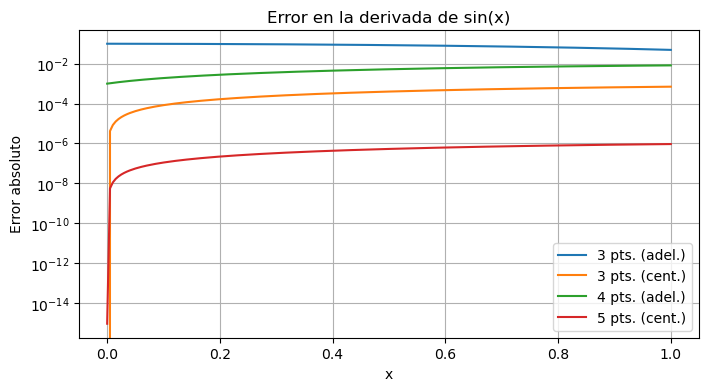

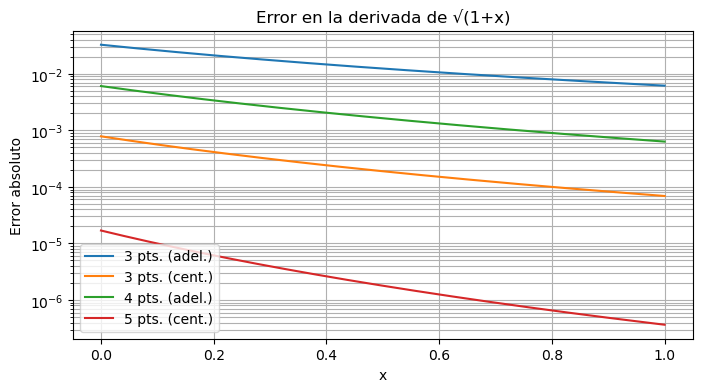

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# ---------- Reutilizamos la función deriva2 ----------
def deriva2(fun, puntos, h):
    x_arr = np.atleast_1d(np.array(puntos, dtype=float))
    h_arr = np.atleast_1d(np.array(h, dtype=float))
    if x_arr.size > 1 and h_arr.size > 1:
        raise ValueError("No se permite que 'puntos' y 'h' sean vectores simultáneamente.")
    if h_arr.size == 1:
        h_arr = np.repeat(h_arr, x_arr.size)
    else:
        x_arr = np.repeat(x_arr, h_arr.size)
    x, hh = x_arr, h_arr
    hh2 = hh**2
    f = fun
    r3a = (f(x) - 2*f(x+hh) + f(x+2*hh)) / hh2
    r3c = (f(x-hh) - 2*f(x) + f(x+hh)) / hh2
    r4a = (2*f(x) - 5*f(x+hh) + 4*f(x+2*hh) - f(x+3*hh)) / hh2
    r5c = (-f(x-2*hh) + 16*f(x-hh) - 30*f(x) + 16*f(x+hh) - f(x+2*hh)) / (12*hh2)
    return np.vstack([r3a, r3c, r4a, r5c]).T

# ---------- Funciones y derivadas exactas ----------
# f1(x) = sin(x)
def f1(x): return np.sin(x)
def f1pp(x): return -np.sin(x)

# f2(x) = sqrt(1 + x)
def f2(x): return np.sqrt(1 + x)
def f2pp(x): return -1 / (4*(1+x)**(3/2))

# ---------- Puntos y paso ----------
x_vals = np.linspace(0, 1, 200)
h = 0.1

# ---------- Errores para f1 ----------
approx1 = deriva2(f1, x_vals, h)
exact1  = f1pp(x_vals)
error1  = np.abs(approx1 - exact1[:, None])

# ---------- Errores para f2 ----------
approx2 = deriva2(f2, x_vals, h)
exact2  = f2pp(x_vals)
error2  = np.abs(approx2 - exact2[:, None])

# ---------- Gráficas ----------
plt.figure(figsize=(8,4))
plt.yscale("log")
plt.plot(x_vals, error1[:,0], label="3 pts. (adel.)")
plt.plot(x_vals, error1[:,1], label="3 pts. (cent.)")
plt.plot(x_vals, error1[:,2], label="4 pts. (adel.)")
plt.plot(x_vals, error1[:,3], label="5 pts. (cent.)")
plt.xlabel("x")
plt.ylabel("Error absoluto")
plt.title("Error en la derivada de sin(x)")
plt.legend()
plt.grid(True, which='both')
plt.show()

plt.figure(figsize=(8,4))
plt.yscale("log")
plt.plot(x_vals, error2[:,0], label="3 pts. (adel.)")
plt.plot(x_vals, error2[:,1], label="3 pts. (cent.)")
plt.plot(x_vals, error2[:,2], label="4 pts. (adel.)")
plt.plot(x_vals, error2[:,3], label="5 pts. (cent.)")
plt.xlabel("x")
plt.ylabel("Error absoluto")
plt.title("Error en la derivada de √(1+x)")
plt.legend()
plt.grid(True, which='both')
plt.show()


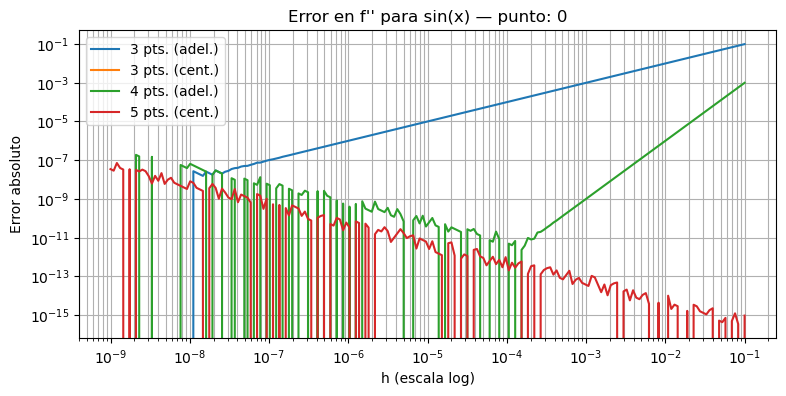

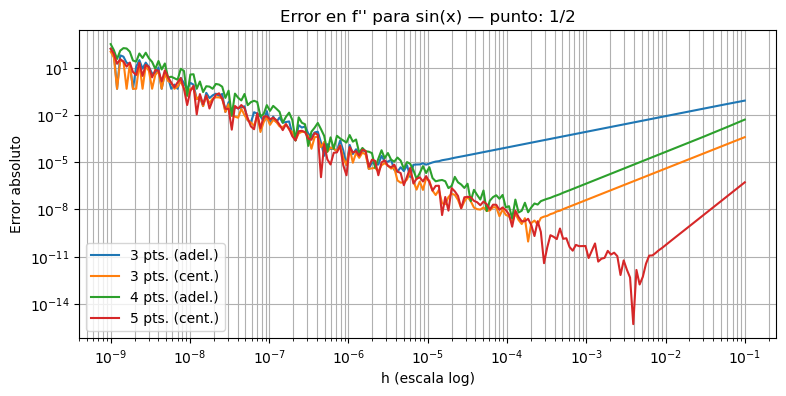

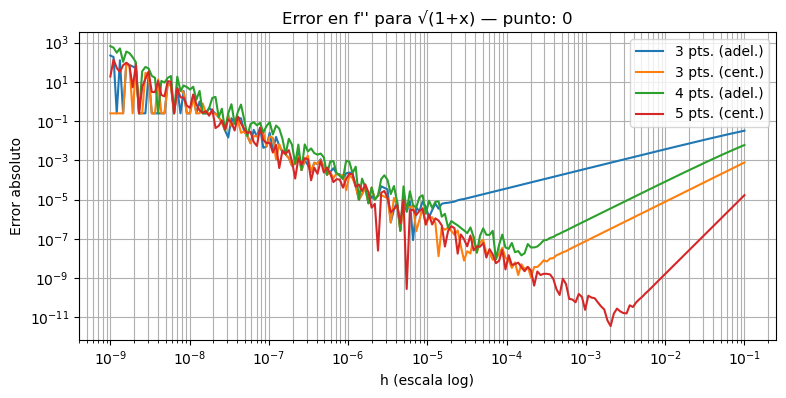

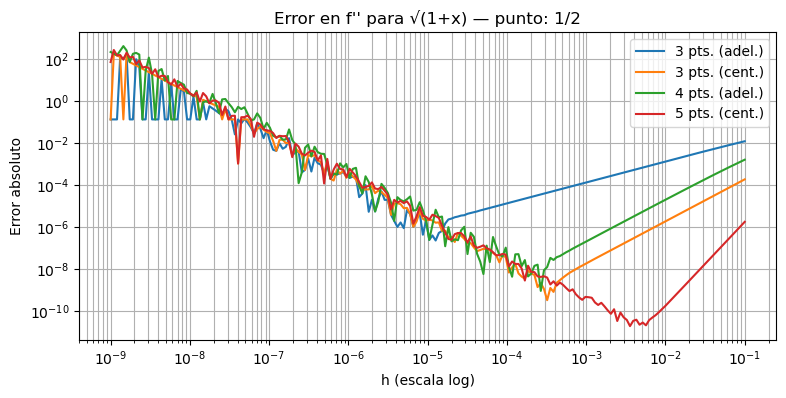

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------ Aproximación de f''(x) con 4 reglas ------------------
def deriva2(fun, puntos, h):
    """
    Devuelve un array shape (N,4) con:
      [ 3pts-adelantada, 3pts-centrada, 4pts-adelantada, 5pts-centrada ]
    - 'puntos' escalar o iterable
    - 'h' escalar o vector (pero no ambos iterables a la vez)
    """
    x_arr = np.atleast_1d(np.array(puntos, dtype=float))
    h_arr = np.atleast_1d(np.array(h, dtype=float))
    if x_arr.size > 1 and h_arr.size > 1:
        raise ValueError("No se permite que 'puntos' y 'h' sean vectores simultáneamente.")
    if h_arr.size == 1:
        h_arr = np.repeat(h_arr, x_arr.size)
    else:
        x_arr = np.repeat(x_arr, h_arr.size)

    x, hh = x_arr, h_arr
    hh2 = hh**2
    f = fun

    r3a = (f(x) - 2*f(x+hh) + f(x+2*hh)) / hh2
    r3c = (f(x-hh) - 2*f(x) + f(x+hh)) / hh2
    r4a = (2*f(x) - 5*f(x+hh) + 4*f(x+2*hh) - f(x+3*hh)) / hh2
    r5c = (-f(x-2*hh) + 16*f(x-hh) - 30*f(x) + 16*f(x+hh) - f(x+2*hh)) / (12*hh2)

    return np.vstack([r3a, r3c, r4a, r5c]).T  # (N,4)

# ------------------ Funciones de prueba y f'' exacta ------------------
def f1(x):       # sin(x)
    return np.sin(x)
def f1pp(x):     # -sin(x)
    return -np.sin(x)

def f2(x):       # sqrt(1+x)
    return np.sqrt(1.0 + x)
def f2pp(x):     # -1/(4*(1+x)^(3/2))
    return -1.0/(4.0*(1.0 + x)**1.5)

# ------------------ Rango de h y puntos a evaluar ------------------
h_vals = np.logspace(-9, -1, 200)   # de 1e-9 a 1e-1
puntos = [0.0, 0.5]                  # {0, 1/2}

# ------------------ Helper para un subplot ------------------
def plot_error(fun, funpp, x0, titulo):
    approx = deriva2(fun, x0, h_vals)       # shape (len(h), 4)
    exact  = funpp(x0)
    err    = np.abs(approx - exact)

    plt.xscale("log")
    plt.yscale("log")
    plt.plot(h_vals, err[:,0], label="3 pts. (adel.)")
    plt.plot(h_vals, err[:,1], label="3 pts. (cent.)")
    plt.plot(h_vals, err[:,2], label="4 pts. (adel.)")
    plt.plot(h_vals, err[:,3], label="5 pts. (cent.)")
    plt.xlabel("h (escala log)")
    plt.ylabel("Error absoluto")
    plt.title(titulo)
    plt.grid(True, which="both")
    plt.legend()

# ------------------ Gráficas pedidas ------------------
plt.figure(figsize=(9,4))
plot_error(f1, f1pp, puntos[0], "Error en f'' para sin(x) — punto: 0")
plt.show()

plt.figure(figsize=(9,4))
plot_error(f1, f1pp, puntos[1], "Error en f'' para sin(x) — punto: 1/2")
plt.show()

plt.figure(figsize=(9,4))
plot_error(f2, f2pp, puntos[0], "Error en f'' para √(1+x) — punto: 0")
plt.show()

plt.figure(figsize=(9,4))
plot_error(f2, f2pp, puntos[1], "Error en f'' para √(1+x) — punto: 1/2")
plt.show()

# (Opcional) para guardar:
# plt.savefig("error_sin_x0.png", dpi=150, bbox_inches="tight")


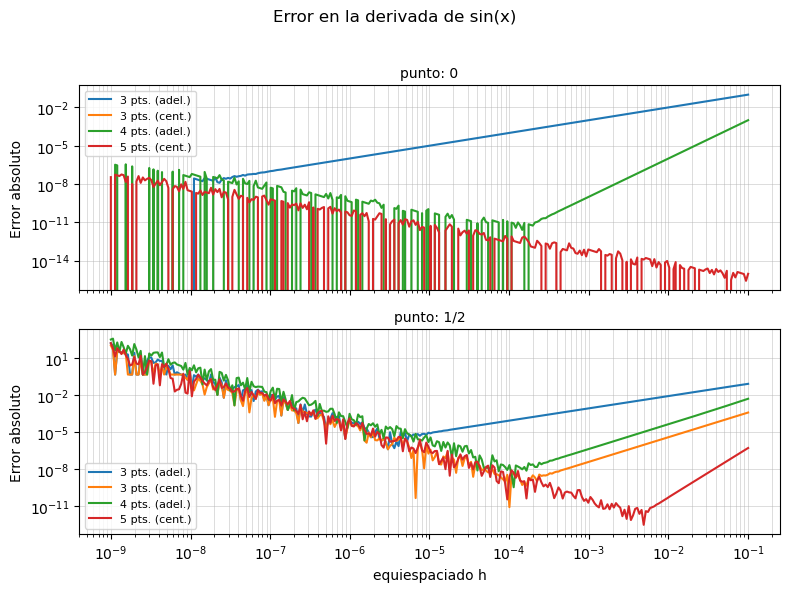

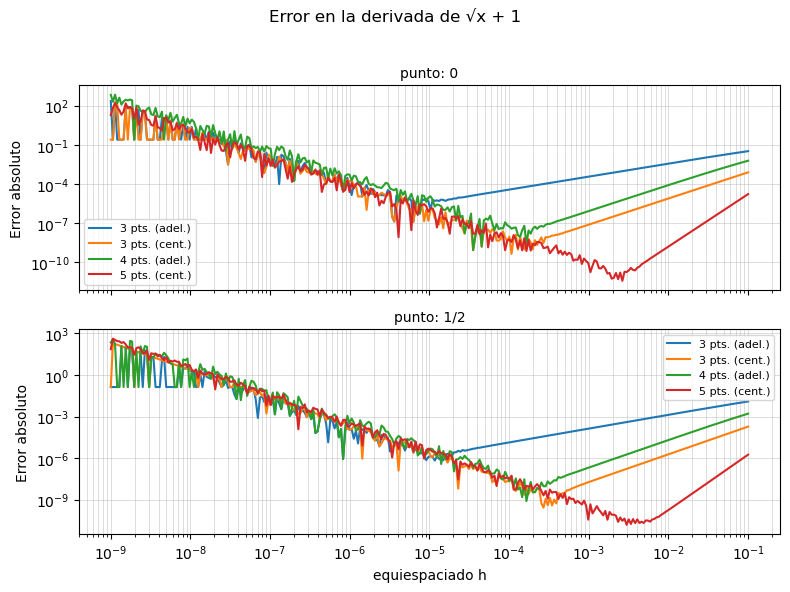

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Reglas para f'' ----------
def deriva2(fun, puntos, h):
    x_arr = np.atleast_1d(np.array(puntos, dtype=float))
    h_arr = np.atleast_1d(np.array(h, dtype=float))
    if x_arr.size > 1 and h_arr.size > 1:
        raise ValueError("No se permite que 'puntos' y 'h' sean vectores simultáneamente.")
    if h_arr.size == 1:
        h_arr = np.repeat(h_arr, x_arr.size)
    else:
        x_arr = np.repeat(x_arr, h_arr.size)
    x, hh = x_arr, h_arr
    hh2 = hh**2
    f = fun
    r3a = (f(x) - 2*f(x+hh) + f(x+2*hh)) / hh2
    r3c = (f(x-hh) - 2*f(x) + f(x+hh)) / hh2
    r4a = (2*f(x) - 5*f(x+hh) + 4*f(x+2*hh) - f(x+3*hh)) / hh2
    r5c = (-f(x-2*hh) + 16*f(x-hh) - 30*f(x) + 16*f(x+hh) - f(x+2*hh)) / (12*hh2)
    return np.vstack([r3a, r3c, r4a, r5c]).T  # (N,4)

# ---------- Funciones y derivadas exactas ----------
def f1(x): return np.sin(x)
def f1pp(x): return -np.sin(x)

def f2(x): return np.sqrt(1.0 + x)
def f2pp(x): return -1.0/(4.0*(1.0 + x)**1.5)

# ---------- Config común ----------
h_vals = np.logspace(-9, -1, 300, endpoint=True)  # como en la lámina
labels = ["3 pts. (adel.)", "3 pts. (cent.)", "4 pts. (adel.)", "5 pts. (cent.)"]

def plot_bloque(fun, funpp, titulo):
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    fig.suptitle(titulo, y=0.98)

    for ax, x0, subt in zip(axs, [0.0, 0.5], ["punto: 0", "punto: 1/2"]):
        approx = deriva2(fun, x0, h_vals)        # (len(h),4)
        exact  = funpp(x0)
        err    = np.abs(approx - exact)

        ax.set_xscale("log"); ax.set_yscale("log")
        for k in range(4):
            ax.plot(h_vals, err[:,k], label=labels[k])
        ax.set_ylabel("Error absoluto")
        ax.set_title(subt, fontsize=10)
        ax.grid(True, which="both", linewidth=0.6, alpha=0.5)
        ax.legend(loc="best", fontsize=8)

    axs[-1].set_xlabel("equiespaciado h")
    fig.tight_layout(rect=[0, 0, 1, 0.96])

# ---------- Generar las 4 gráficas en 2 bloques ----------
plot_bloque(f1, f1pp, "Error en la derivada de sin(x)")
plot_bloque(f2, f2pp, "Error en la derivada de \N{SQUARE ROOT}x + 1")
plt.show()


**Aplicaciones de la integración**

In [8]:
import numpy as np
import scipy as sc
import sympy as sp
import scipy.interpolate as scip
import scipy.integrate as scin
import matplotlib.pyplot as plt
sp.init_printing( use_unicode = True )

In [10]:
# Datos
r = np.array ([0 , 2 , 4 , 5 , 6 , 7 , 8 , 8.5 , 9 , 9.5 , 10]) /10 # dm
u = np.array ([3 , 2.95 , 2.85 , 2.75 , 2.6 , 2.3 , 1.9 , 1.6 , 1.2 , 0.6 , 0]) *10 # dm / s
f = 2* np.pi * r * u

# Interpolantes
spl = scip.CubicSpline (r , f )
pol = scip.BarycentricInterpolator (r , f )

In [11]:
# Calculos de las áreas ( caudales )
Atrap = scin.trapezoid (f , r )
Asimp = scin.simpson (f , r )
Aspl = spl.integrate ( r [0] , r [ -1])
Apol , k = scin.quad ( pol , r [0] , r [ -1])

Atrap = 63.33450789637023
Asimp = 63.71149901480101
Aspl  = 63.774444475375056
Apol  = -140.48472936131625


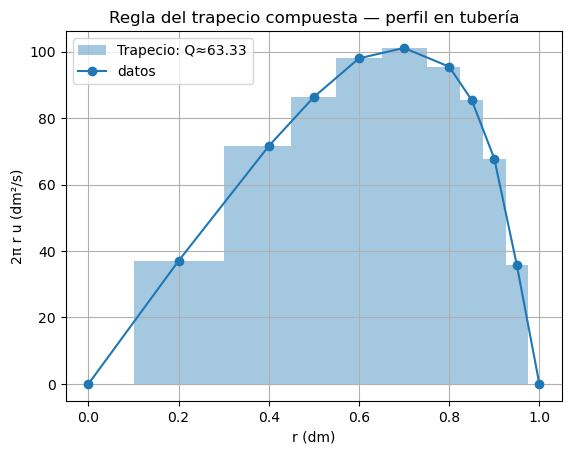

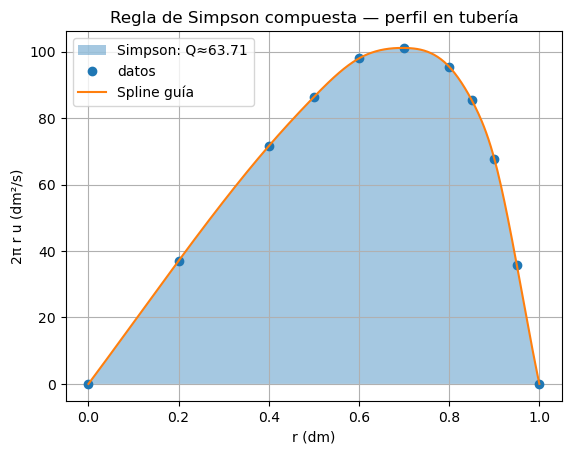

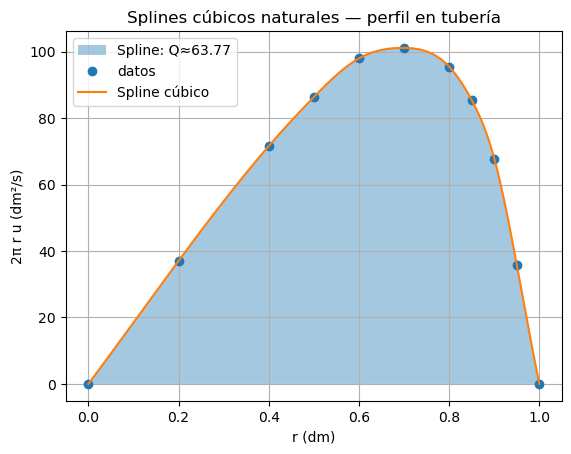

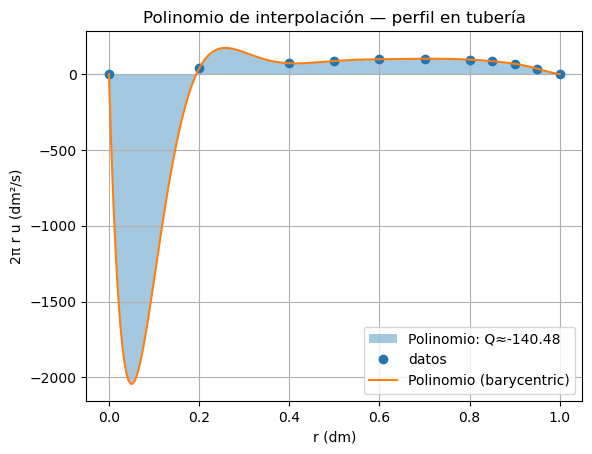

In [12]:
import numpy as np
import scipy.interpolate as scip
import scipy.integrate as scin
import matplotlib.pyplot as plt

# --------- Datos ---------
r = np.array([0, 2, 4, 5, 6, 7, 8, 8.5, 9, 9.5, 10]) / 10.0  # dm
u = np.array([3, 2.95, 2.85, 2.75, 2.6, 2.3, 1.9, 1.6, 1.2, 0.6, 0]) * 10.0  # dm/s
f = 2 * np.pi * r * u   # integrando 2π r u (dm^2/s)

# --------- Interpolantes ---------
spl = scip.CubicSpline(r, f)                 # spline cúbico natural
pol = scip.BarycentricInterpolator(r, f)     # polinomio de interpolación (barycentric)

# --------- Caudales (áreas) ---------
Atrap = scin.trapezoid(f, r)
Asimp = scin.simpson(f, x=r)                 # ojo: x=r como keyword
Aspl  = float(spl.integrate(r[0], r[-1]))
Apol, _ = scin.quad(lambda x: float(pol(x)), r[0], r[-1])

print(f"Atrap = {Atrap}")
print(f"Asimp = {Asimp}")
print(f"Aspl  = {Aspl}")
print(f"Apol  = {Apol}")

# --------- Figuras ---------
r_dense = np.linspace(r[0], r[-1], 400)
f_spl = spl(r_dense)
f_pol = pol(r_dense)

# 1) Trapecio
plt.figure()
plt.fill_between(r, 0, f, alpha=0.4, step='mid', label=f"Trapecio: Q≈{Atrap:.2f}")
plt.plot(r, f, marker='o', linestyle='-', label="datos")
plt.xlabel("r (dm)"); plt.ylabel("2π r u (dm²/s)")
plt.title("Regla del trapecio compuesta — perfil en tubería")
plt.legend(); plt.grid(True)
plt.show()

# 2) Simpson
plt.figure()
plt.fill_between(r_dense, 0, spl(r_dense), alpha=0.4, label=f"Simpson: Q≈{Asimp:.2f}")
plt.plot(r, f, 'o', label="datos")
plt.plot(r_dense, spl(r_dense), label="Spline guía")
plt.xlabel("r (dm)"); plt.ylabel("2π r u (dm²/s)")
plt.title("Regla de Simpson compuesta — perfil en tubería")
plt.legend(); plt.grid(True)
plt.show()

# 3) Spline cúbico (integrado exacto)
plt.figure()
plt.fill_between(r_dense, 0, f_spl, alpha=0.4, label=f"Spline: Q≈{Aspl:.2f}")
plt.plot(r, f, 'o', label="datos")
plt.plot(r_dense, f_spl, label="Spline cúbico")
plt.xlabel("r (dm)"); plt.ylabel("2π r u (dm²/s)")
plt.title("Splines cúbicos naturales — perfil en tubería")
plt.legend(); plt.grid(True)
plt.show()

# 4) Polinomio de interpolación
plt.figure()
plt.fill_between(r_dense, 0, f_pol, alpha=0.4, label=f"Polinomio: Q≈{Apol:.2f}")
plt.plot(r, f, 'o', label="datos")
plt.plot(r_dense, f_pol, label="Polinomio (barycentric)")
plt.xlabel("r (dm)"); plt.ylabel("2π r u (dm²/s)")
plt.title("Polinomio de interpolación — perfil en tubería")
plt.legend(); plt.grid(True)
plt.show()


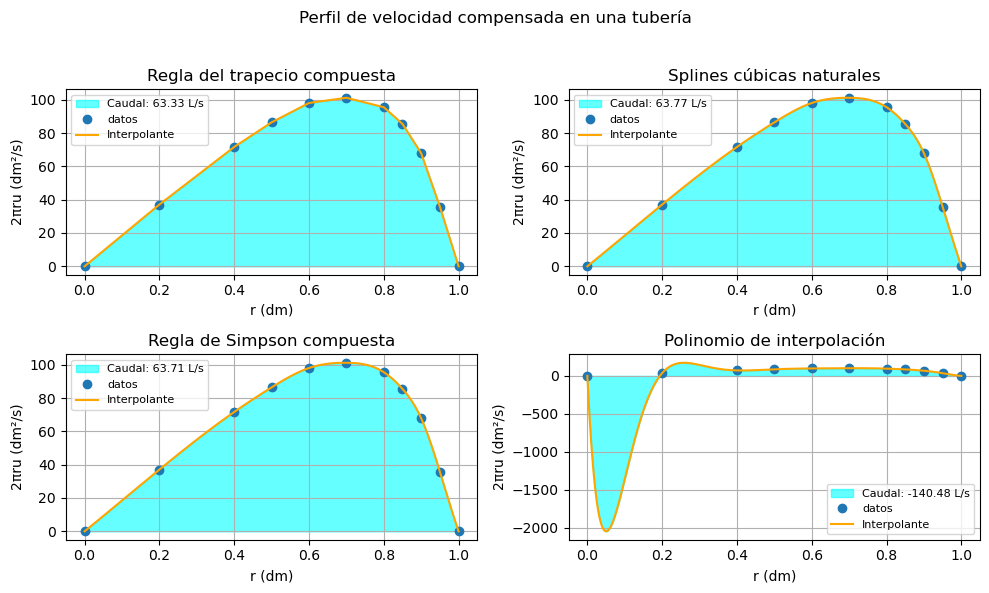

In [13]:
import numpy as np
import scipy.interpolate as scip
import scipy.integrate as scin
import matplotlib.pyplot as plt

# -------- Datos --------
r = np.array([0, 2, 4, 5, 6, 7, 8, 8.5, 9, 9.5, 10]) / 10.0  # dm
u = np.array([3, 2.95, 2.85, 2.75, 2.6, 2.3, 1.9, 1.6, 1.2, 0.6, 0]) * 10.0  # dm/s
f = 2 * np.pi * r * u   # integrando 2π r u (dm²/s)

# -------- Interpolantes --------
spl = scip.CubicSpline(r, f)
pol = scip.BarycentricInterpolator(r, f)

# -------- Integración (caudales) --------
Atrap = scin.trapezoid(f, r)
Asimp = scin.simpson(f, x=r)
Aspl  = float(spl.integrate(r[0], r[-1]))
Apol, _ = scin.quad(lambda x: float(pol(x)), r[0], r[-1])

# -------- Puntos densos para curvas --------
r_dense = np.linspace(r[0], r[-1], 400)
f_spl = spl(r_dense)
f_pol = pol(r_dense)

# -------- Gráficas (2x2) --------
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Perfil de velocidad compensada en una tubería", fontsize=12, y=0.98)

# --- (1) Trapecio ---
ax = axs[0, 0]
ax.fill_between(r, 0, f, color='cyan', alpha=0.6, label=f"Caudal: {Atrap:.2f} L/s")
ax.plot(r, f, 'o', label='datos')
ax.plot(r, f, 'orange', label='Interpolante')
ax.set_title("Regla del trapecio compuesta")
ax.legend(fontsize=8)
ax.grid(True)

# --- (2) Spline cúbico ---
ax = axs[0, 1]
ax.fill_between(r_dense, 0, f_spl, color='cyan', alpha=0.6, label=f"Caudal: {Aspl:.2f} L/s")
ax.plot(r, f, 'o', label='datos')
ax.plot(r_dense, f_spl, 'orange', label='Interpolante')
ax.set_title("Splines cúbicas naturales")
ax.legend(fontsize=8)
ax.grid(True)

# --- (3) Simpson ---
ax = axs[1, 0]
ax.fill_between(r_dense, 0, spl(r_dense), color='cyan', alpha=0.6, label=f"Caudal: {Asimp:.2f} L/s")
ax.plot(r, f, 'o', label='datos')
ax.plot(r_dense, spl(r_dense), 'orange', label='Interpolante')
ax.set_title("Regla de Simpson compuesta")
ax.legend(fontsize=8)
ax.grid(True)

# --- (4) Polinomio de interpolación ---
ax = axs[1, 1]
ax.fill_between(r_dense, 0, f_pol, color='cyan', alpha=0.6, label=f"Caudal: {Apol:.2f} L/s")
ax.plot(r, f, 'o', label='datos')
ax.plot(r_dense, f_pol, 'orange', label='Interpolante')
ax.set_title("Polinomio de interpolación")
ax.legend(fontsize=8)
ax.grid(True)

# Etiquetas generales
for ax in axs.flat:
    ax.set(xlabel="r (dm)", ylabel="2πru (dm²/s)")

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Atrap = 0.063335 m³/s  (63.33 L/s)
Asimp = 0.063711 m³/s  (63.71 L/s)
Aspl  = 0.063774 m³/s  (63.77 L/s)
Apol  = -0.140485 m³/s  (-140.48 L/s)


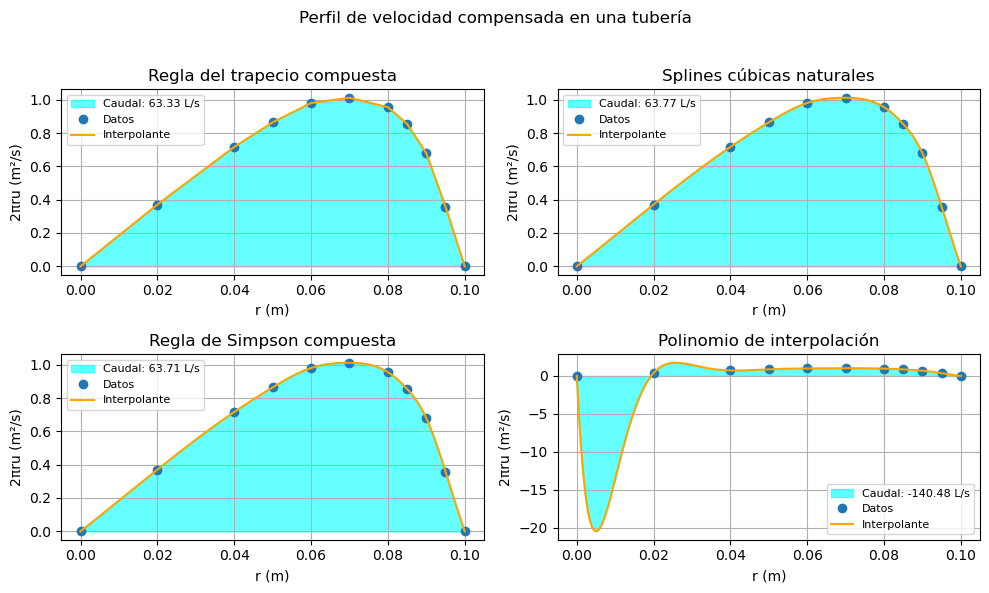

In [14]:
import numpy as np
import scipy.interpolate as scip
import scipy.integrate as scin
import matplotlib.pyplot as plt

# -------- 1. Datos --------
# Radio (cm → dm → m): pasamos a metros directamente
r = np.array([0, 2, 4, 5, 6, 7, 8, 8.5, 9, 9.5, 10]) / 100  # metros
u = np.array([3, 2.95, 2.85, 2.75, 2.6, 2.3, 1.9, 1.6, 1.2, 0.6, 0])  # m/s

# Integrando: 2π·r·u  (m²/s)
f = 2 * np.pi * r * u

# -------- 2. Interpolantes --------
spl = scip.CubicSpline(r, f)
pol = scip.BarycentricInterpolator(r, f)

# -------- 3. Integración (caudales) --------
Atrap = scin.trapezoid(f, r)
Asimp = scin.simpson(f, x=r)
Aspl  = float(spl.integrate(r[0], r[-1]))
Apol, _ = scin.quad(lambda x: float(pol(x)), r[0], r[-1])

# Conversión: m³/s → L/s (1 m³/s = 1000 L/s)
Atrap_L = Atrap * 1000
Asimp_L = Asimp * 1000
Aspl_L  = Aspl  * 1000
Apol_L  = Apol  * 1000

print(f"Atrap = {Atrap:.6f} m³/s  ({Atrap_L:.2f} L/s)")
print(f"Asimp = {Asimp:.6f} m³/s  ({Asimp_L:.2f} L/s)")
print(f"Aspl  = {Aspl:.6f} m³/s  ({Aspl_L:.2f} L/s)")
print(f"Apol  = {Apol:.6f} m³/s  ({Apol_L:.2f} L/s)")

# -------- 4. Gráficas 2×2 --------
r_dense = np.linspace(r[0], r[-1], 400)
f_spl = spl(r_dense)
f_pol = pol(r_dense)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Perfil de velocidad compensada en una tubería", fontsize=12, y=0.98)

# --- Trapecio ---
ax = axs[0, 0]
ax.fill_between(r, 0, f, color='cyan', alpha=0.6, label=f"Caudal: {Atrap_L:.2f} L/s")
ax.plot(r, f, 'o', label='Datos')
ax.plot(r, f, 'orange', label='Interpolante')
ax.set_title("Regla del trapecio compuesta")
ax.legend(fontsize=8)
ax.grid(True)

# --- Spline cúbico ---
ax = axs[0, 1]
ax.fill_between(r_dense, 0, f_spl, color='cyan', alpha=0.6, label=f"Caudal: {Aspl_L:.2f} L/s")
ax.plot(r, f, 'o', label='Datos')
ax.plot(r_dense, f_spl, 'orange', label='Interpolante')
ax.set_title("Splines cúbicas naturales")
ax.legend(fontsize=8)
ax.grid(True)

# --- Simpson ---
ax = axs[1, 0]
ax.fill_between(r_dense, 0, spl(r_dense), color='cyan', alpha=0.6, label=f"Caudal: {Asimp_L:.2f} L/s")
ax.plot(r, f, 'o', label='Datos')
ax.plot(r_dense, spl(r_dense), 'orange', label='Interpolante')
ax.set_title("Regla de Simpson compuesta")
ax.legend(fontsize=8)
ax.grid(True)

# --- Polinomio ---
ax = axs[1, 1]
ax.fill_between(r_dense, 0, f_pol, color='cyan', alpha=0.6, label=f"Caudal: {Apol_L:.2f} L/s")
ax.plot(r, f, 'o', label='Datos')
ax.plot(r_dense, f_pol, 'orange', label='Interpolante')
ax.set_title("Polinomio de interpolación")
ax.legend(fontsize=8)
ax.grid(True)

# Etiquetas comunes
for ax in axs.flat:
    ax.set(xlabel="r (m)", ylabel="2πru (m²/s)")

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**Aplicaciones de la integración**

In [15]:
import numpy as np
import sympy as sp
import scipy.integrate as scin

# --- 1) Definición de la función e intervalos ---
a, b = 0.0, 10.0
x = sp.symbols('x', real=True)

# f(x) = e^{-x^2/2} / sqrt(2*pi)
f_expr = sp.exp(-x**2 / 2) / sp.sqrt(2*sp.pi)
f = sp.lambdify(x, f_expr, modules=["numpy"])   # versión numérica para SciPy

# --- 2) Valor "exacto" con Sympy ---
I_exact = float(sp.integrate(f_expr, (x, a, b)))

# --- 3) Integración numérica ---
# quad (adaptativa) -> devuelve (valor, error_estimado)
I_quad, err_est_quad = scin.quad(f, a, b)

# fixed_quad (cuadratura de Gauss-Legendre fija). Por defecto n=5.
# Devuelve (valor, None). No tiene estimación de error.
I_fixed, _ = scin.fixed_quad(f, a, b)  # n=5

# --- 4) Errores reales ---
err_real_quad  = abs(I_exact - I_quad)
err_real_fixed = abs(I_exact - I_fixed)

# --- 5) Presentación ---
print("Función\t\tResultado\t\tError estimado\t\tError real")
print(f"quad\t\t{I_quad:.17f}\t{err_est_quad:.3e}\t{err_real_quad:.3e}")
print(f"fixed-quad\t{I_fixed:.17f}\t{'-':>13}\t\t{err_real_fixed:.15f}")

# (Opcional) probar fixed_quad con más nodos para ver mejora:
# for n in (5, 10, 20, 40):
#     In, _ = scin.fixed_quad(f, a, b, n=n)
#     print(f"fixed_quad n={n:>2}: valor={In:.17f}, error real={abs(I_exact-In):.3e}")


Función		Resultado		Error estimado		Error real
quad		0.50000000000000011	4.336e-10	1.110e-16
fixed-quad	0.48997020423422549	            -		0.010029795765775


In [16]:
import sympy as sp
from collections.abc import Iterable

def incoef_base(soporte, a, b, *, exacto=True):
    """
    Coeficientes de una regla de integración basada en Lagrange.
    
    soporte : lista/tupla de nodos x_k
    a, b    : límites de integración
    exacto  : si True devuelve valores exactos (Sympy); si False, float

    Devuelve: lista [alpha_k] con ∫_a^b L_k(x) dx
    """
    # --- 1) Comprobaciones ---
    if not isinstance(soporte, (list, tuple)):
        raise TypeError("El soporte debe ser lista o tupla.")
    if len(soporte) < 1:
        raise ValueError("El soporte no puede estar vacío.")

    # --- 2) Polinomios de Lagrange con sympy (exactos) ---
    x = sp.symbols('x')
    xs = [sp.nsimplify(s) for s in soporte]   # racionaliza si es posible
    n  = len(xs)
    alphas = []
    for k in range(n):
        # L_k(x)
        num, den = 1, 1
        xk = xs[k]
        for j, xj in enumerate(xs):
            if j == k: 
                continue
            num *= (x - xj)
            den *= (xk - xj)
        Lk = sp.simplify(num/den)
        # --- 3) Integrar en [a,b] ---
        integ = sp.integrate(Lk, (x, sp.nsimplify(a), sp.nsimplify(b)))
        alphas.append(sp.simplify(integ))

    if exacto:
        return alphas
    else:
        return [float(sp.N(c)) for c in alphas]

# ------------------ Verificación con los 3 casos de la tabla ------------------

# Caso 1: x_k = (8/3){1,2,3,4}, [a,b] = [8/3, 32/3]  → α = {1, 3, 3, 1}
xs1 = [(sp.Rational(8,3))*i for i in (1,2,3,4)]
a1, b1 = sp.Rational(8,3), sp.Rational(32,3)
coef1 = incoef_base(xs1, a1, b1, exacto=True)        # exacto
coef1_simpl = [sp.simplify(c) for c in coef1]

# Caso 2: x_k = {1,2,3,4}, [a,b] = [0,24]            → α = {11, 1, 1, 11}
xs2 = [1,2,3,4]
a2, b2 = 0, 24
coef2 = incoef_base(xs2, a2, b2, exacto=True)
coef2_simpl = [sp.simplify(c) for c in coef2]

# Caso 3: x_k = {1,2,3,4}, [a,b] = [0,4]             → α = {8/3, -4/3, 8/3, 0}
xs3 = [1,2,3,4]
a3, b3 = 0, 4
coef3 = incoef_base(xs3, a3, b3, exacto=True)
coef3_simpl = [sp.simplify(c) for c in coef3]

print("Caso 1:", coef1_simpl)   # [1, 3, 3, 1]
print("Caso 2:", coef2_simpl)   # [11, 1, 1, 11]
print("Caso 3:", coef3_simpl)   # [8/3, -4/3, 8/3, 0]

# --- Propiedad de suma de coeficientes: sum α_k = b - a ---
assert sp.simplify(sum(coef1) - (b1 - a1)) == 0
assert sp.simplify(sum(coef2) - (b2 - a2)) == 0
assert sp.simplify(sum(coef3) - (b3 - a3)) == 0

# --- (Opcional) Simetría: si los nodos son simétricos y [a,b] es simétrico,
#     entonces los α_k también lo son.
def es_simetrico(alphas, tol=sp.Rational(0)):
    return all(sp.simplify(alphas[i] - alphas[-1-i]) == tol for i in range(len(alphas)//2))

print("Suma correcta (casos 1–3) y simetría caso 1:", es_simetrico(coef1))


Caso 1: [1, 3, 3, 1]
Caso 2: [-8064, 25632, -27264, 9720]
Caso 3: [8/3, -4/3, 8/3, 0]
Suma correcta (casos 1–3) y simetría caso 1: True


In [17]:
import sympy as sp

def incoef_base(soporte, a, b):
    """
    Calcula los coeficientes α_k = ∫_a^b L_k(x) dx
    usando los polinomios de Lagrange del soporte dado.
    """
    if not isinstance(soporte, (list, tuple)):
        raise TypeError("El soporte debe ser lista o tupla.")
    if len(soporte) < 1:
        raise ValueError("El soporte no puede estar vacío.")

    x = sp.symbols('x')
    xs = [sp.nsimplify(s) for s in soporte]
    n = len(xs)
    alphas = []
    for k in range(n):
        num, den = 1, 1
        for j in range(n):
            if j == k:
                continue
            num *= (x - xs[j])
            den *= (xs[k] - xs[j])
        Lk = sp.simplify(num / den)
        integ = sp.integrate(Lk, (x, sp.nsimplify(a), sp.nsimplify(b)))
        alphas.append(sp.simplify(integ))
    return alphas

# ---- Casos de la tabla ----

# Caso 1
xs1 = [(sp.Rational(8,3))*i for i in (1,2,3,4)]
a1, b1 = sp.Rational(8,3), sp.Rational(32,3)
coef1 = incoef_base(xs1, a1, b1)

# Caso 2
xs2 = [(sp.Rational(24,5))*i for i in (1,2,3,4)]
a2, b2 = 0, 24
coef2 = incoef_base(xs2, a2, b2)

# Caso 3
xs3 = [1,2,3,4]
a3, b3 = 0, 4
coef3 = incoef_base(xs3, a3, b3)

print("Caso 1:", coef1)   # → [1, 3, 3, 1]
print("Caso 2:", coef2)   # → [11, 1, 1, 11]
print("Caso 3:", coef3)   # → [8/3, -4/3, 8/3, 0]

# Verificación de propiedad de suma
for (a,b,coef) in [(a1,b1,coef1),(a2,b2,coef2),(a3,b3,coef3)]:
    print("Suma:", sp.simplify(sum(coef)), "==", sp.simplify(b-a))


Caso 1: [1, 3, 3, 1]
Caso 2: [11, 1, 1, 11]
Caso 3: [8/3, -4/3, 8/3, 0]
Suma: 8 == 8
Suma: 24 == 24
Suma: 4 == 4


In [2]:
import sympy as sp

# ====== coeficientes de integración por base de Lagrange ======
def incoef_base(soporte, a, b):
    """
    Devuelve los coeficientes α_k = ∫_a^b L_k(x) dx
    para la base de Lagrange definida en 'soporte'.
    (Valores exactos con Sympy)
    """
    x = sp.symbols('x')
    xs = [sp.nsimplify(s) for s in soporte]
    a, b = sp.nsimplify(a), sp.nsimplify(b)

    alphas = []
    for k, xk in enumerate(xs):
        num, den = 1, 1
        for j, xj in enumerate(xs):
            if j == k: 
                continue
            num *= (x - xj)
            den *= (xk - xj)
        Lk = sp.simplify(num/den)
        alphas.append(sp.simplify(sp.integrate(Lk, (x, a, b))))
    return alphas

def aplicar_phi(xs, a, b, c, d):
    """Aplica φ(x)=c x + d a nodos e intervalo."""
    xs2 = [sp.nsimplify(c)*sp.nsimplify(x) + sp.nsimplify(d) for x in xs]
    a2  = sp.nsimplify(c)*sp.nsimplify(a) + sp.nsimplify(d)
    b2  = sp.nsimplify(c)*sp.nsimplify(b) + sp.nsimplify(d)
    return xs2, a2, b2

def verifica_afine(xs, a, b, c, d, titulo=""):
    """Comprueba β = c * α bajo φ(x)=c x + d."""
    alpha = incoef_base(xs, a, b)           # coeficientes originales
    xs2, a2, b2 = aplicar_phi(xs, a, b, c, d)
    beta  = incoef_base(xs2, a2, b2)        # coeficientes transformados
    pred  = [sp.simplify(sp.nsimplify(c)*a_) for a_ in alpha]   # <-- c * α
    ok = all(sp.simplify(b_ - p_) == 0 for b_, p_ in zip(beta, pred))
    print(f"{titulo}  ->  {'OK' if ok else 'FALTA'}")
    print("  α   =", alpha)
    print("  β   =", beta)
    print("  c·α =", pred, "\n")
    assert ok, "La relación afín β = c·α no se cumple"

# ====== Casos base (del Ejemplo 28) ======
# 1) x = (8/3){1,2,3,4}, [8/3, 32/3]   → α = {1,3,3,1}
xs1 = [sp.Rational(8,3)*i for i in (1,2,3,4)]
a1, b1 = sp.Rational(8,3), sp.Rational(32,3)

# 2) x = (24/5){1,2,3,4}, [0,24]       → α = {11,1,1,11}
xs2 = [sp.Rational(24,5)*i for i in (1,2,3,4)]
a2, b2 = 0, 24

# 3) x = {1,2,3,4}, [0,4]              → α = {8/3, -4/3, 8/3, 0}
xs3 = [1,2,3,4]
a3, b3 = 0, 4

# ====== Verificaciones de la tabla del Ejemplo 29 ======
# Fila 1: φ(x) = (3/8)x - 2   →  nodos {-1,0,1,2},   [a,b]=[-1,2]
verifica_afine(xs1, a1, b1, c=sp.Rational(3,8), d=-2, titulo="Fila 1")

# Fila 2: φ(x) = (10/24)x + 5 →  nodos {7,9,11,13}, [a,b]=[5,15]
verifica_afine(xs2, a2, b2, c=sp.Rational(10,24), d=5, titulo="Fila 2")

# Fila 3: φ(x) = 3x - 3       →  nodos {0,3,6,9},    [a,b]=[-3,9]
verifica_afine(xs3, a3, b3, c=3, d=-3, titulo="Fila 3")


Fila 1  ->  OK
  α   = [1, 3, 3, 1]
  β   = [3/8, 9/8, 9/8, 3/8]
  c·α = [3/8, 9/8, 9/8, 3/8] 

Fila 2  ->  OK
  α   = [11, 1, 1, 11]
  β   = [55/12, 5/12, 5/12, 55/12]
  c·α = [55/12, 5/12, 5/12, 55/12] 

Fila 3  ->  OK
  α   = [8/3, -4/3, 8/3, 0]
  β   = [8, -4, 8, 0]
  c·α = [8, -4, 8, 0] 



In [3]:
# Comprobación adicional: suma de coeficientes tras la transformación
def suma_ok(xs, a, b, c, d):
    xs2, a2, b2 = aplicar_phi(xs, a, b, c, d)
    beta = incoef_base(xs2, a2, b2)
    return sp.simplify(sum(beta) - (b2 - a2)) == 0

print("Suma fila 1:", suma_ok(xs1, a1, b1, sp.Rational(3,8), -2))
print("Suma fila 2:", suma_ok(xs2, a2, b2, sp.Rational(10,24), 5))
print("Suma fila 3:", suma_ok(xs3, a3, b3, 3, -3))


Suma fila 1: True
Suma fila 2: True
Suma fila 3: True


In [8]:
import numpy as np

def in_romberg(fun, a, b, nivel=10, tol=1e-6):
    """
    Método de Romberg basado directamente en el algoritmo del ejemplo.
    Devuelve:
      - valor estimado de la integral
      - error estimado (última corrección δ)
      - tabla completa N
    """
    # 1. Crear matriz cuadrada N
    N = np.zeros((nivel, nivel), dtype=float)

    # 2. Primer valor (trapecio simple)
    h = b - a
    N[0, 0] = 0.5 * h * (fun(a) + fun(b))

    # 3. Repetir hasta 'nivel-1'
    for n in range(1, nivel):
        # (a) Reducir el paso a la mitad
        h = h / 2.0
        # (b) Calcular p puntos nuevos
        p = 2 ** (n - 1)
        xi = a + h * (2 * np.arange(1, p + 1) - 1)
        s = np.sum(fun(xi))
        # (c) Nuevo valor de la fila (trapecio compuesta)
        N[n, 0] = 0.5 * N[n - 1, 0] + h * s

        # (d) Extrapolación de Richardson
        q = 1.0
        for j in range(1, n + 1):
            q *= 4
            delta = (N[n, j - 1] - N[n - 1, j - 1]) / (q - 1)
            N[n, j] = N[n, j - 1] + delta

        # (e) Criterio de parada
        if abs(delta) < tol:
            return N[n, j], abs(delta), N[:n + 1, :n + 1]

    # Si no converge antes, devuelve el último valor
    return N[n, j], abs(delta), N



In [9]:
import numpy as np

f = lambda x: np.cos(x)
a, b = 0, np.pi/2

valor, err, tabla = in_romberg(f, a, b, nivel=10, tol=1e-6)

print("Resultado:", valor)
print("Error estimado:", err)
print("Tabla de Romberg:")
print(np.round(tabla, 7))

Resultado: 1.0000000081440208
Error estimado: 1.3191673481437865e-07
Tabla de Romberg:
[[0.7853982 0.        0.        0.       ]
 [0.9480594 1.0022799 0.        0.       ]
 [0.9871158 1.0001346 0.9999916 0.       ]
 [0.9967852 1.0000083 0.9999999 1.       ]]


In [15]:
valor, err, tabla = in_romberg(f, a, b, nivel=10, tol=1e-10)

print("Resultado:", valor)
print("Error estimado:", err)
print("Tabla de Romberg:")
print(np.round(tabla, 7))

Resultado: 0.9999999999980171
Error estimado: 3.1820326765676006e-11
Tabla de Romberg:
[[0.7853982 0.        0.        0.        0.       ]
 [0.9480594 1.0022799 0.        0.        0.       ]
 [0.9871158 1.0001346 0.9999916 0.        0.       ]
 [0.9967852 1.0000083 0.9999999 1.        0.       ]
 [0.9991967 1.0000005 1.        1.        1.       ]]


In [16]:
import numpy as np

def in_romberg(fun, a, b, nivel=10, tol=1e-6):
    N = np.zeros((nivel, nivel), dtype=float)
    h = b - a
    N[0, 0] = 0.5 * h * (fun(a) + fun(b))
    
    for n in range(1, nivel):
        h /= 2
        p = 2**(n - 1)
        xi = a + h * (2 * np.arange(1, p + 1) - 1)
        s = np.sum(fun(xi))
        N[n, 0] = 0.5 * N[n - 1, 0] + h * s
        
        q = 1.0
        for j in range(1, n + 1):
            q *= 4
            delta = (N[n, j - 1] - N[n - 1, j - 1]) / (q - 1)
            N[n, j] = N[n, j - 1] + delta

        if abs(delta) < tol:
            return N[n, j], abs(delta), N[:n + 1, :n + 1]
    
    return N[n, j], abs(delta), N

# ---------- Formato tabla como en el apunte ----------
def imprime_tabla_romberg(tabla, a, b):
    print(f"{'n':>2} {'h':>10}  " + "  ".join([f'N{i}' for i in range(tabla.shape[1])]))
    for i in range(tabla.shape[0]):
        h = (b - a) / (2**i)
        fila = "  ".join(f"{tabla[i,j]:>10.7f}" for j in range(i+1))
        print(f"{i+1:2d} {h:10.7f}  {fila}")

# ---------- Ejemplo: ∫ cos(x) dx de 0 a π/2 ----------
f = lambda x: np.cos(x)
a, b = 0, np.pi/2

valor, err, tabla = in_romberg(f, a, b, nivel=10, tol=1e-12)
print(f"\nResultado: {valor}")
print(f"Error estimado: {err}\n")
imprime_tabla_romberg(tabla, a, b)



Resultado: 1.0000000000000002
Error estimado: 1.936541510401886e-15

 n          h  N0  N1  N2  N3  N4  N5
 1  1.5707963   0.7853982
 2  0.7853982   0.9480594   1.0022799
 3  0.3926991   0.9871158   1.0001346   0.9999916
 4  0.1963495   0.9967852   1.0000083   0.9999999   1.0000000
 5  0.0981748   0.9991967   1.0000005   1.0000000   1.0000000   1.0000000
 6  0.0490874   0.9997992   1.0000000   1.0000000   1.0000000   1.0000000   1.0000000
